In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
row1 = session.query(Measurement).first()
row1.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2353430be48>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [11]:
row1 = session.query(Station).first()
row1.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2353430b9b0>,
 'elevation': 3.0,
 'id': 1,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

# Exploratory Climate Analysis

### Precipitation Analysis

In [151]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from today

# Perform a query to retrieve the data and precipitation scores

query = session.query(*[Measurement.date, Measurement.prcp]).filter(func.strftime("%Y-%m", Measurement.date)>= '2017-07-08')

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(query.statement, session.bind, index_col='date')

# Sort the dataframe by date
df_sorted_by_date = df.sort_index()
df_sorted_by_date.dropna(inplace=True)

<IPython.core.display.Javascript object>


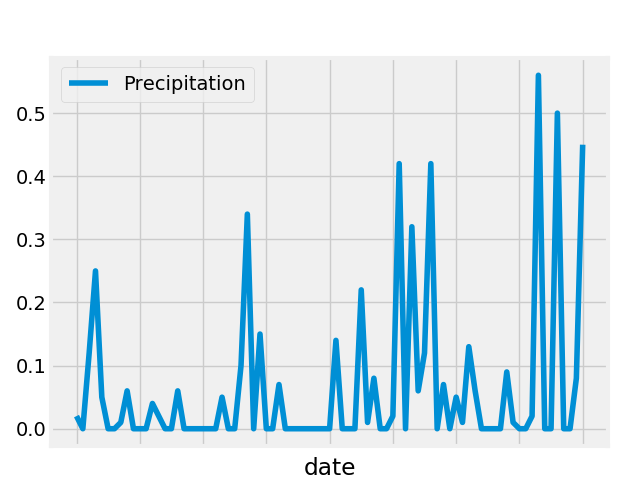

In [152]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
df_sorted_by_date.plot(ax=ax)
ax.legend(['Precipitation'])

In [150]:
# Statistics
df_sorted_by_date.describe()

,prcp
count,1968.000000
mean,0.171479
std,0.451817
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [133]:
# Create a query to calculate the total number of stations
stations = session.query(Measurement.station).distinct().all()
print(len(stations))

9


In [158]:
# Create a query to find the most active stations.
sel = [Measurement.station, func.count(Measurement.station)]
# List the stations and observation counts in descending order
stations_and_tobs = session.query(*sel).group_by(Measurement.station).order_by(-func.count(Measurement.station)).all()
stations_and_tobs

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [159]:
# Which station has the highest number of observations?
station_with_highest_observations = stations_and_tobs[0][0]
station_with_highest_observations

'USC00519281'

In [160]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel_stats = [func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)]
session.query(*sel_stats).filter(Measurement.station == station_with_highest_observations).all()

[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


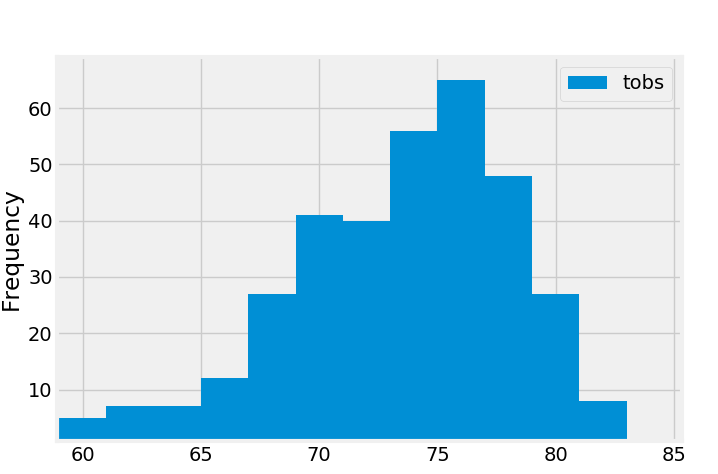

In [147]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
sel_tobs = [Measurement.tobs]

query_last_12_mons = session.query(*sel_tobs).filter(func.strftime("%Y-%m", Measurement.date)> '2016-08').filter(Measurement.station == station_with_highest_observations)

# plot the results as a histogram with bins=12
df_tobs = pd.read_sql(query_last_12_mons.statement, session.bind, columns=['tobs'])
ax = df_tobs.plot.hist(bins=12)

### Temperature Analysis

In [161]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [170]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacation_start = '2017-07-01'
vacation_end = '2017-07-11'
print(*calc_temps(vacation_start, vacation_end)[0])

69.0 78.03030303030303 87.0


In [163]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [164]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

